In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [23]:
pkl_file = open("Data/Yerevan_population.pkl", "rb")
population = pickle.load(pkl_file)
pkl_file.close()
print(population[0])
#print(population[1])
#print(population)

[    0.             0.             0.             0.
     0.             0.             0.             0.
   506.30775073     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.          4430.19281887
     0.             0.             0.             0.
     0.             0.             0.             0.
  1898.65406523     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.           970.42318889
     0.             0.             0.             0.
     0.             0.        

In [3]:
population.shape   # (84, 549) - 84 = (12 (2-hours blocks)*7(weekdays)). 549 => Number of cells 

(84, 549)

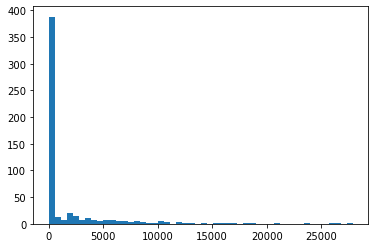

In [19]:
plt.hist(population[4], bins=50)
plt.show()

In [7]:
pkl_file = open("Data/Yerevan_OD_matrices.pkl", "rb")
OD_matrices = pickle.load(pkl_file)
pkl_file.close()
print(OD_matrices)

[[[ 42.   0.   0. ...   0.   0.   0.]
  [  0.  42.   0. ...   0.   0.   0.]
  [  0.   0.  42. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 853.   0.   0.]
  [  0.   0.   0. ...   0.  42.   0.]
  [  0.   0.   0. ...   0.   0.  42.]]

 [[ 76.   0.   0. ...   0.   0.   0.]
  [  0.  76.   0. ...   0.   0.   0.]
  [  0.   0.  76. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 765.   0.   0.]
  [  0.   0.   0. ...   0.  76.   0.]
  [  0.   0.   0. ...   0.   0.  76.]]

 [[ 63.   0.   0. ...   0.   0.   0.]
  [  0.  63.   0. ...   0.   0.   0.]
  [  0.   0.  63. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 765.   0.   0.]
  [  0.   0.   0. ...   0.  63.   0.]
  [  0.   0.   0. ...   0.   0.  63.]]

 ...

 [[ 17.   0.   0. ...   0.   0.   0.]
  [  0.  17.   0. ...   0.   0.   0.]
  [  0.   0.  17. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 444.   0.   0.]
  [  0.   0.   0. ...   0.  17.   0.]
  [  0.   0.   0. ...   0.   0.  17.]]

 [[ 20.   0.   0. ...   0.   0.   0.]
  [  0.  20.

In [9]:
OD_matrices.shape  # (84, 549) For each time step, we have an Origin-Destination matrix. 12 (number og 2-hours blocks during a day) * 7 (number of days) = 84 (number of O-D matrices). 549. Number of regions. 

(84, 549, 549)

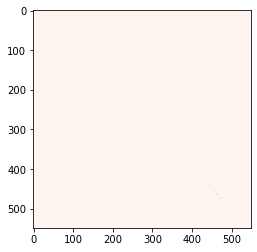

In [27]:
plt.imshow(OD_matrices[6], cmap='Reds')  # Most of the movement is along the diagonal == staying within a region.
# 6 -> Midday during the first day 
plt.show()

In [28]:
# Most people stays in the same area -> diagonal has the largest sum
print("On-diagonal sum: ", np.diagonal(OD_matrices[6]).sum())
print("Off-diagonal sum: ", OD_matrices[6].sum() - np.diagonal(OD_matrices[6]).sum())

On-diagonal sum:  840187.0
Off-diagonal sum:  157476.0


## Covid-19 model

In [29]:
from collections import namedtuple

In [30]:
Param = namedtuple('Param', 'R0 DE DI I0 HospitalisationRate HospiterIters')
# I0 is the distribution of infected people at time t=0, if None then randomly choose inf number of people

In [32]:
# flow is a 3D matrix of dimensions r x n x n (i.e., 84 x 549 x 549),
# flow[t mod r] is the desired OD matrix at time t. Use mod in order to only need one week of OD- matrices. 

def seir(par, distr, flow, alpha, iterations, inf):
    """
    parameters:
        - par: parameters
        - distr: population distribution
        - flow: OD matrices
        - alpha: strength of lock down measures/movement restriction. value of 1 - normal flow, 0 - no flow 
        - iterations: number of simulations/ duration of simulation
        - inf: number of infections
    returns: 
        - res: matrix of shape (#iterations, #compartments" + 1(hospitalized people))
        - history: matrix with the number of subjects in each compartment [sim_it, compartment_id, num_cells]
    """
    r = flow.shape[0]   # Number of OD matrices - Ex. 84  
    n = flow.shape[1]   # Number of cells - Ex. 549
    N = distr[0].sum()  # Total population. We assume that N = sum(flow) 
    
    # Initialize compartments - assume everyone starts in S
    Svec = distr[0].copy()  
    Evec = np.zeros(n)
    Ivec = np.zeros(n)
    Rvec = np.zeros(n)
    
    # If initial infectious is None, choose inf random infectious
    if par.I0 is None:
        initial = np.zeros(n)
        for i in range(inf):
            loc = np.random.randint(n)
            if (Svec[loc] > initial[loc]):  
                initial[loc] += 1.0             
    else:
        initial = par.I0
    assert ((Svec < initial).sum() == 0)  # Make sure that number of suceptible > infected for every region
    
    # Remove infected from S, and add infected to I 
    Svec =- initial
    Ivec =+ initial
    
    # res matrix of shape (#iterations, #compartments" + 1(hospitalized people)).
    res = np.zeros((iterations, 5))
    res[0,:] = [Svec.sum(), Evec.sum(), Ivec.sum(), Rvec.sum()]

    # Normalise the flows and then multiply them by the alpha values. OBS: alpha actually represents 
    # non-linear action!
    realflow = flow.copy() # copy!
    realflow = realflow / realflow.sum(axis=2)[:,:, np.newaxis]    
    realflow = alpha * realflow    
    
    history = np.zeros((iterations, 5, n)) # 5 beacuse of number of compartments
    history[0,0,:] = Svec
    history[0,1,:] = Evec
    history[0,2,:] = Ivec
    history[0,3,:] = Rvec
    
    eachIter = np.zeros(iterations + 1)
    
    # run simulation
    for iter in range(0, iterations - 1):
        realOD = realflow[iter % r]  # Stays within one week
        
        d = distr[iter % r] + 1  # At least one person in each cell. To avoid normalization problems. 
        
        # Partial differential equations
        newE = Svec * Ivec / d * par.R0 / par.DI
        newI = Evec / par.DE
        newR = Ivec / par.DI
        
        Svec -= newE
        Svec = (Svec 
               + np.matmul(Svec.reshape(1,n), realOD)
               - Svec * realOD.sum(axis=1)
                )
        Evec = Evec + newE - newI
        Evec = (Evec 
               + np.matmul(Evec.reshape(1,n), realOD)
               - Evec * realOD.sum(axis=1)
                )
                
        Ivec = Ivec + newI - newR
        Ivec = (Ivec 
               + np.matmul(Ivec.reshape(1,n), realOD)
               - Ivec * realOD.sum(axis=1)
                )
                
        Rvec += newR
        Rvec = (Rvec 
               + np.matmul(Rvec.reshape(1,n), realOD)
               - Rvec * realOD.sum(axis=1)
                )
                
        res[iter + 1,:] = [Svec.sum(), Evec.sum(), Ivec.sum(), Rvec.sum(), 0]
        eachIter[iter + 1] = newI.sum()
        res[iter + 1, 4] = eachIter[max(0, iter - par.HospiterIters) : iter].sum() * par.HospitalisationRate
        
        history[iter + 1,0,:] = Svec
        history[iter + 1,1,:] = Evec
        history[iter + 1,2,:] = Ivec
        history[iter + 1,3,:] = Rvec
    return res, history